In [0]:
!git clone https://github.com/take2rohit/denoising_autoencoder.git

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Move files outside the repo

In [0]:
mv /content/denoising_autoencoder/* /content/

# Import Files

In [0]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

## The classes imported below are used for dataloader, transformation and model

from DAE_dataset_helper import OrigamiDatasetGenerate
from DAE_dataset_helper import ToTensor, Resize, Normalize
from DAE_model import AugmentedAutoencoder # contains various models to be tested on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
train_batch_size = 8
test_batch_size = 8
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

origami_dataset_dir = "MarowDataset"
inp='Input'
out='Output'

trns = transforms.Compose([Resize((128,128)),Normalize(), ToTensor()])

origami = OrigamiDatasetGenerate(root_dir=origami_dataset_dir,inp=inp, out=out, transform=trns)

train_loader = DataLoader(origami, batch_size=train_batch_size, shuffle=True,**kwargs)

Shape:  torch.Size([8, 3, 128, 128])
<built-in method max of type object at 0x7fea44f90300>


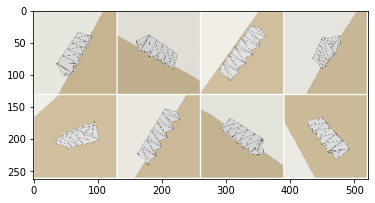

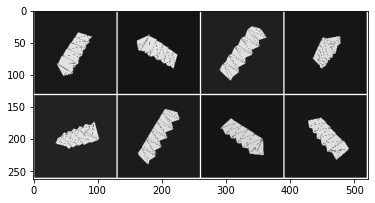

In [17]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']
print('Shape: ', augmented.shape)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images_show = 8
print(torch.max)
imshow(torchvision.utils.make_grid(augmented[:images_show,:], nrow=4, padding=2, pad_value=1))
imshow(torchvision.utils.make_grid(original[:images_show,:], nrow=4, padding=2, pad_value=1))

In [0]:
def train(model, device, train_loader, optimizer, epoch,log_interval=30):
    model.train()
    l2 = nn.MSELoss()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = l2(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))
    scheduler.step()

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    l2 = nn.MSELoss()
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += l2(output, target) # sum up batch loss
    test_loss /= c

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

model = AugmentedAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

save_model = False
epochs = 50
load_model = False

if load_model:
    model.load_state_dict(torch.load('/content/drive/My Drive/MarowTrack/denoising_ae.pt'))
else:
  for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, train_loader)

if save_model:
    torch.save(model.state_dict(), '/content/drive/My Drive/MarowTrack/denoising_ae.pt')

Train Epoch: 1 	Loss: 0.093603
Train Epoch: 1 	Loss: 0.047655
Train Epoch: 1 	Loss: 0.037381
Train Epoch: 1 	Loss: 0.032418
Train Epoch: 1 	Loss: 0.036325
Train Epoch: 1 	Loss: 0.035177
Train Epoch: 1 	Loss: 0.035815
Train Epoch: 1 	Loss: 0.033473
Train Epoch: 1 	Loss: 0.028218
Train Epoch: 1 	Loss: 0.038239

Test set: Average loss: 0.0330

Train Epoch: 2 	Loss: 0.025440
Train Epoch: 2 	Loss: 0.028862
Train Epoch: 2 	Loss: 0.042143
Train Epoch: 2 	Loss: 0.031785
Train Epoch: 2 	Loss: 0.030036
Train Epoch: 2 	Loss: 0.034142
Train Epoch: 2 	Loss: 0.036220
Train Epoch: 2 	Loss: 0.035385
Train Epoch: 2 	Loss: 0.033234
Train Epoch: 2 	Loss: 0.030763

Test set: Average loss: 0.0274

Train Epoch: 3 	Loss: 0.030951
Train Epoch: 3 	Loss: 0.019001
Train Epoch: 3 	Loss: 0.016365
Train Epoch: 3 	Loss: 0.015660
Train Epoch: 3 	Loss: 0.015265
Train Epoch: 3 	Loss: 0.015247
Train Epoch: 3 	Loss: 0.014656
Train Epoch: 3 	Loss: 0.013022
Train Epoch: 3 	Loss: 0.013142
Train Epoch: 3 	Loss: 0.011862

Tes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed


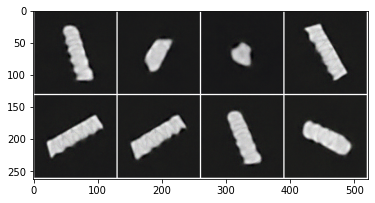

Input to Netowrk


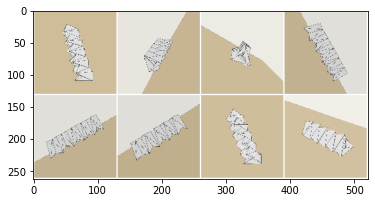

Ground Truth


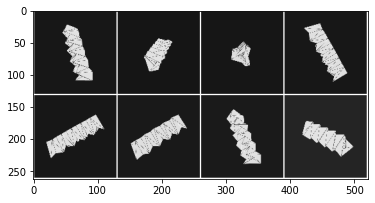

In [12]:
def cross_validation(model, device, test_loader,viewer=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        data, target = sample['augmented'],sample['original']
        
        data, target = data.to(device), target.to(device)
        output = model(data)
        

    if viewer:
        images_show = 8
        
        print('Reconstructed')
        op = output[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(op, nrow=4, padding=2, pad_value=1))
                
        print('Input to Netowrk')
        imshow(torchvision.utils.make_grid(data[:images_show,:].cpu(), nrow=4, padding=2, pad_value=1))  
        
        print('Ground Truth')
        imshow(torchvision.utils.make_grid(target[:images_show,:].cpu(), nrow=4, padding=2, pad_value=1))

    return data,target, output

input_network, target, output = cross_validation(model, device, train_loader,viewer=True)